# Nigerian Crop Disease Detection - Google Colab Starter


In [1]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch==2.6.0 torchvision==0.17.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu118
!pip install fastai

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 102.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 127.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168

In [2]:
# Cell 1: Setup and Installation
print("Setting up Nigerian Crop Disease Detection Project")
print("=" * 50)

# Install required packages
!pip install timm kaggle gradio plotly seaborn -q

# Import libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import timm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
import json
import time
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.auto import tqdm

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")



Setting up Nigerian Crop Disease Detection Project
PyTorch version: 2.6.0+cu124
Device: CUDA


In [3]:
from google.colab import files
import os

# Upload kaggle.json (from your Kaggle account)
files.upload()

os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download and unzip the PlantVillage dataset
!kaggle datasets download -d abdallahalidev/plantvillage-dataset -p /content/data --unzip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 99% 2.02G/2.04G [00:29<00:00, 60.5MB/s]
100% 2.04G/2.04G [00:29<00:00, 74.9MB/s]


In [4]:
import os

for folder in ['plantvillage dataset', 'plantvillage']:
    p = f"/content/data/{folder}"
    print(f"\nListing contents in: {p}")
    if os.path.exists(p):
        print(os.listdir(p)[:10])
    else:
        print("Folder does not exist.")


Listing contents in: /content/data/plantvillage dataset
['grayscale', 'segmented', 'color']

Listing contents in: /content/data/plantvillage
Folder does not exist.


In [5]:
# Cell 2: NigerianCropDataset (robust and PyTorch-compatible)
import torch
from torch.utils.data import Dataset
from PIL import Image
from pathlib import Path

class NigerianCropDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform

        # 1. List class folders, SORTED alphabetically for consistent 0...N-1 indices
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        # 2. Build mapping: class_name -> index
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        # 3. Build (image_path, class_idx) pairs for all images in all class folders
        self.samples = []
        for class_name in self.classes:
            class_folder = self.root_dir / class_name
            for img_file in class_folder.iterdir():
                if img_file.suffix.lower() in ('.jpg', '.jpeg', '.png'):
                    self.samples.append((img_file, self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

Detected classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', '

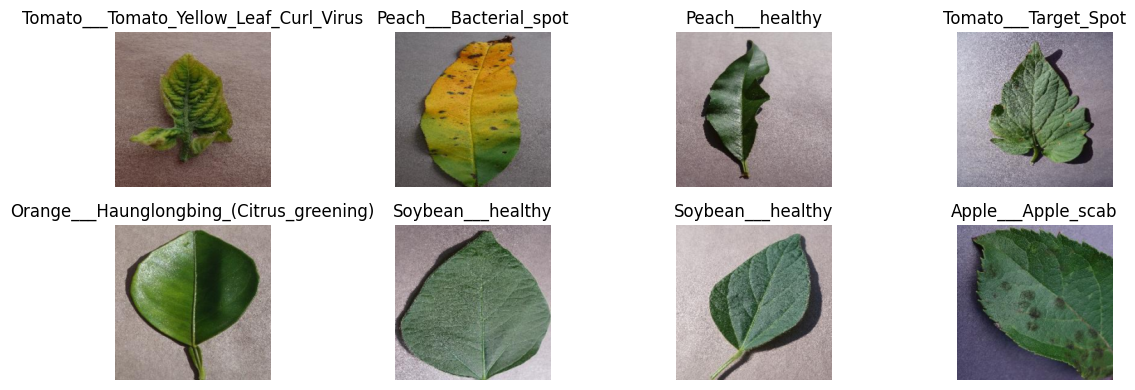

In [6]:
# Cell 4: Transforms and DataLoaders (updated for correct PlantVillage data root)

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize images to 224x224
    transforms.ToTensor(),                 # Convert PIL Image to PyTorch Tensor
    transforms.Normalize(                  # Normalize with ImageNet mean and std (common for transfer learning)
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 2. Set the correct dataset root directory (where images actually are)
data_root = "/content/data/plantvillage dataset/color"

# 3. Create the dataset
train_dataset = NigerianCropDataset(data_root, transform=transform)

# 4. Check classes and dataset stats
print("Detected classes:", train_dataset.classes)
print(f"Total images in dataset: {len(train_dataset)}")

# 5. Create DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=32,          # Set batch size (adjust as needed)
    shuffle=True,           # Shuffle for training
    num_workers=2,          # Number of subprocesses for data loading (try 2 for Colab)
    pin_memory=True         # Pin memory for faster transfer to GPU (optional, helpful if using CUDA)
)

# 6. Preview a batch of images and labels (optional, for verification)
def imshow(img_tensor, title=None):
    """Display a tensor as an image after denormalizing."""
    img = img_tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Get one batch
images, labels = next(iter(train_loader))
plt.figure(figsize=(12, 4))
for i in range(min(8, images.size(0))):
    plt.subplot(2, 4, i+1)
    imshow(images[i].cpu(), title=train_dataset.classes[labels[i]])
plt.tight_layout()
plt.show()

In [7]:
# Cell 5: Define Model Architectures for Comparison
class ModelComparator:
    def __init__(self, num_classes=4):
        self.num_classes = num_classes
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.models = {}
        self.results = {}

    def create_model(self, model_name):
        """Create and return model based on architecture name"""
        if model_name == 'MobileNetV3Small':
            model = timm.create_model('mobilenetv3_small_100', pretrained=True, num_classes=self.num_classes)
        elif model_name == 'EfficientNetLite0':
            model = timm.create_model('tf_efficientnet_lite0', pretrained=True, num_classes=self.num_classes)
        elif model_name == 'SqueezeNet1_1':
            model = timm.create_model('squeezenet1_1', pretrained=True, num_classes=self.num_classes)
        elif model_name == 'ResNet18':
            model = timm.create_model('resnet18', pretrained=True, num_classes=self.num_classes)
        else:
            raise ValueError(f"Unknown model: {model_name}")

        return model.to(self.device)

    def get_model_info(self, model):
        """Get model parameter count and size estimation"""
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        param_size = total_params * 4  # 4 bytes per parameter (float32)
        size_mb = param_size / (1024 * 1024)
        return {
            'total_params': total_params,
            'trainable_params': trainable_params,
            'size_mb': size_mb
        }

    def quick_train_test(self, model_name, train_loader, epochs=1):
        """Quick training for comparison (few epochs for demo)"""
        print(f"\nTraining {model_name}...")
        model = self.create_model(model_name)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        model.train()
        for epoch in range(epochs):
            running_loss = 0.0
            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            avg_loss = running_loss / len(train_loader)
            print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")
        info = self.get_model_info(model)
        print(f"{model_name} - Parameters: {info['total_params']}, Model Size (MB): {info['size_mb']:.2f}")



In [8]:
images, labels = next(iter(train_loader))
print("Labels in batch:", labels)
print("Max label:", labels.max(), "Min label:", labels.min())

Labels in batch: tensor([ 4, 17,  8, 35,  4, 30, 15, 33, 11, 19, 35,  2, 13, 15, 24, 28, 34, 35,
        28, 33, 30, 35,  5,  4,  4, 15, 33,  3, 35, 30, 35, 16])
Max label: tensor(35) Min label: tensor(2)


In [ ]:
# Cell 6: Run Comparison

# 1. Ensure num_classes is set
num_classes = len(train_dataset.classes)

# 2. Create comparator and run quick train/test
comparator = ModelComparator(num_classes=num_classes)
for model_name in ["MobileNetV3Small", "EfficientNetLite0", "ResNet18"]:
    comparator.quick_train_test(model_name, train_loader, epochs=1)


Training MobileNetV3Small...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

Epoch 1:   0%|          | 0/1698 [00:00<?, ?it/s]

Epoch 1 Loss: 0.3849
MobileNetV3Small - Parameters: 1556806, Model Size (MB): 5.94

Training EfficientNetLite0...


model.safetensors:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

Epoch 1:   0%|          | 0/1698 [00:00<?, ?it/s]

Epoch 1 Loss: 0.1808
EfficientNetLite0 - Parameters: 3419686, Model Size (MB): 13.05

Training ResNet18...


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Epoch 1:   0%|          | 0/1698 [00:00<?, ?it/s]

In [ ]:
# Cell 7: Visualization (optional)
# Plot a few images from the dataset
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img, label = train_dataset[i]
    axs[i].imshow(img.permute(1, 2, 0))
    axs[i].set_title(train_dataset.classes[label])
    axs[i].axis('off')
plt.tight_layout()
plt.show()